In [132]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline

import scipy.optimize as opt  
from aprendizado_maquina import regressao_logistica as lg

In [133]:
data = pd.read_csv('data/ex2data2.txt', header=None, names=['Teste 1', 'Teste 2', 'Aceito'])  
data.head()

,Teste 1,Teste 2,Aceito
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


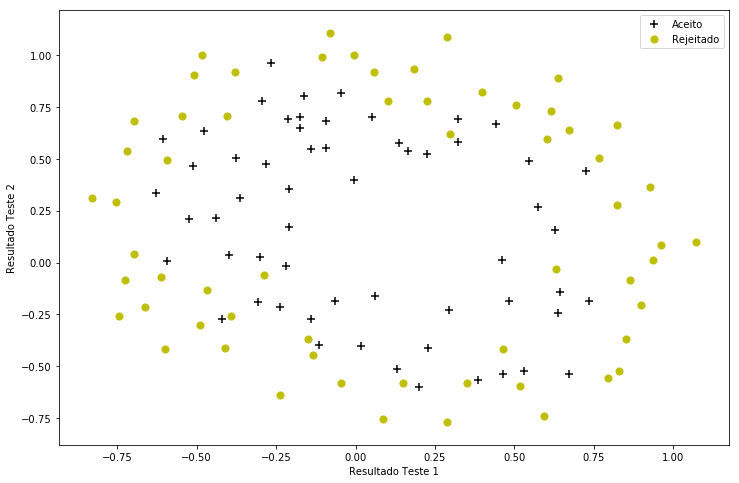

In [134]:
positive = data[data['Aceito'].isin([1])]  
negative = data[data['Aceito'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['Teste 1'], positive['Teste 2'], s=50, c='k', marker='+', label='Aceito')  
ax.scatter(negative['Teste 1'], negative['Teste 2'], s=50, c='y', marker='o', label='Rejeitado')  
ax.legend()  
ax.set_xlabel('Resultado Teste 1')  
ax.set_ylabel('Resultado Teste 2')  

### Aplicando a regularização ao modelo

In [135]:
grau_polinomio = 6 

Adicionando um coluna preenchida com '1'

### Mapeamento de características (feature mapping)

In [136]:
def mapearCaracteristicas(c1, c2, grau_polinomio):
    assert grau_polinomio >= 1
    
    def iterar():
        for i in range(1, grau_polinomio + 1):
            for j in range(i + 1):
                yield np.power(c1, i - j) * np.power(c2, j)
    return np.vstack(iterar())

In [137]:
data.insert(3, 'Ones', 1)

In [138]:
x1 = data['Teste 1']  
x2 = data['Teste 2']

for i in range(1, grau_polinomio):
    for j in range(0, i):
        data['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data.drop('Teste 1', axis=1, inplace=True)  
data.drop('Teste 2', axis=1, inplace=True)

Exibindo a nova formatação dos dados

In [139]:
data.head() 

,Aceito,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43,F50,F51,F52,F53,F54
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551,3.541519e-07,0.000005,0.000066,0.000900,0.012278
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801,-6.860919e-06,0.000051,-0.000374,0.002764,-0.020412
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895,-4.457837e-04,0.001444,-0.004677,0.015151,-0.049077
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494,-7.415771e-03,0.009931,-0.013299,0.017810,-0.023851
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818,-3.561597e-02,0.032312,-0.029315,0.026596,-0.024128


### Função de Gradiente

Para a nova função de custo regularizada, foi adicionado um novo parametros **taxa_aprendizado**, esse hiperparametro servirá para sintonizar o peso da regularização.

A variavél **regularizacao** servirá como penalização a medida que o custo da função cresça.

In [140]:
def custo_regressao_logistica_regularizada(theta, X, y, taxa_aprendizado):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    primeiro = np.multiply(-y, np.log(lg.sigmoide(X * theta.T)))
    segundo = np.multiply((1 - y), np.log(1 - lg.sigmoide(X * theta.T)))
    regularizacao = (taxa_aprendizado / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(primeiro - segundo) / (len(X)) + regularizacao

Nova função de gradiente descendente com regularização. Assim como na função de custo, o termo de regularização foi adicionado ao cálculo.

Porém o primeiro termo não deve ser regularizado, pois ele será o nosso viés.

In [141]:
def gradiente_descendente_batch_regularizado(theta, X, y, taxa_aprendizado):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parametros = int(theta.ravel().shape[1])
    grad = np.zeros(parametros)

    erro = lg.sigmoide(X * theta.T) - y

    for i in range(parametros):
        termo = np.multiply(erro, X[:,i])

        if (i == 0):
            grad[i] = np.sum(termo) / len(X)
        else:
            grad[i] = (np.sum(termo) / len(X)) + ((taxa_aprendizado / len(X)) * theta[:,i])

    return grad

In [174]:
# converte de dataframes para arrays
cols = data.shape[1]  
X = data.iloc[:,1:cols]  
y = data.iloc[:,0:1]

# converte em arrays do numpy
X = np.array(X.values)  
y = np.array(y.values)  
theta = np.zeros(cols-1)

alpha = 0.000001

In [175]:
custo_regressao_logistica_regularizada(theta, X, y, alpha)

0.6931471805599454

In [176]:
resultado = opt.fmin_tnc(func=custo_regressao_logistica_regularizada, x0=theta, fprime=gradiente_descendente_batch_regularizado, args=(X, y, alpha))  
resultado  

(array([  0.5594822 ,  -0.92808453,   7.5866964 ,  -7.50504789,
          9.00341552,  10.50923798,  -0.3086287 , -17.76339992,
          0.96461005, -20.66302913,   9.2200711 ,  -4.46014899,
         -2.35747409,   8.31613851, -10.65276826,  -5.26586293]), 104, 4)

In [177]:
theta_min = np.matrix(resultado[0])
theta_min

matrix([[  0.5594822 ,  -0.92808453,   7.5866964 ,  -7.50504789,
           9.00341552,  10.50923798,  -0.3086287 , -17.76339992,
           0.96461005, -20.66302913,   9.2200711 ,  -4.46014899,
          -2.35747409,   8.31613851, -10.65276826,  -5.26586293]])

In [178]:
predicoes = lg.predizer(theta_min, X)

corretas = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predicoes, y)]  
precisao = (sum(map(int, corretas)) % len(corretas))  
print('precisão do modelo = {0}%'.format(precisao))

precisão do modelo = 93%


### Esboço da Fronteira de Decisão

In [ ]:
dim = np.linspace(-1, 1.5, 1000)
dx, dy = np.meshgrid(dim, dim)

v = mapearCaracteristicas(dx.flatten(), dy.flatten(), grau_polinomio=6)